In [1]:
"""Loading and caculating returns

Demonstration of how to load and calculate returns in LUSID.

Attributes
----------
Returns
"""

'Loading and caculating returns\n\nDemonstration of how to load and calculate returns in LUSID.\n\nAttributes\n----------\nReturns\n'

# Setup LUSID

In [2]:
# Import general purpose packages
import os
import json
from datetime import datetime, timedelta
from tqdm import tqdm

# Import lusid specific packages
import lusid
import lusid.models as models
from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Import data wrangling packages
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 500)


# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

In [3]:
# Import ploting libraries and configuration
import matplotlib.pyplot as plt

# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs

plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations

params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

In [4]:
# define a scope to hold data

scope = "tests"
portfolio_code = "UK_EQUITY"

In [5]:
# define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)

In [6]:
# define dates
start_date = datetime(year=2020, month=1, day=2)
number_of_days = 366

# Create a DataFrame of returns

In [7]:
def generate_set_of_returns(start_date, daily_return, start_mv, number_of_days):

    # Create a timeseries of returns for T+1 onwards
    dates = [start_date + timedelta(days=x) for x in range(1, number_of_days)]
    daily_returns = [daily_return] * (number_of_days - 1)
    df = pd.DataFrame({"date": dates, "daily_returns": daily_returns})
    df["cumulative_sum"] = df["daily_returns"].cumsum()
    df["market_value"] = df["cumulative_sum"].apply(lambda x: (x + 1) * 1000000)

    # insert the T details
    returns_on_t = {
        "date": [start_date],
        "daily_returns": [0],
        "market_value": [start_mv],
    }

    # Merge the dfs
    df = pd.concat([pd.DataFrame(returns_on_t), df], ignore_index=True)

    return df

In [8]:
start_date = datetime(year=2020, month=1, day=1)

returns_df = generate_set_of_returns(start_date, 0.0001, 1000000, 366)

# Create a portfolio

In [9]:
portfolios = [portfolio_code]

for port in portfolios:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port, code=port, created="2020-01-01", base_currency="GBP"
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id UK_EQUITY because it already exists in scope tests.


# Upload returns into LUSID

In [10]:
return_code = "daily_returns"

for index, row in tqdm(returns_df.iterrows(), total=returns_df.shape[0]):

    portfolios_api.upsert_portfolio_returns(
        scope=scope,
        code=portfolio_code,
        return_code=return_code,
        return_scope=scope,
        model_return=[
            models.ModelReturn(
                effective_at=row["date"].isoformat()[:10],
                return_value=row["daily_returns"],
                market_value=row["market_value"],
                period="Daily",
            )
        ],
    )

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [03:10<00:00,  1.92it/s]


# Retrieve returns from LUSID

In [11]:
from_effective_at = "2020-01-01"
to_effective_at = "2020-12-31"

returns = portfolios_api.get_portfolio_aggregate_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    from_effective_at=from_effective_at,
    to_effective_at=to_effective_at,
    period="Daily",
    output_frequency="Daily",
    metrics=["INC", "WTD", "MTD", "QTD", "YTD"],
)

In [12]:
data = returns.values

In [13]:
summary_df = pd.DataFrame(
    columns=["date", "mv", "inception", "wtd", "mtd", "qtd", "ytd"]
)

for item in data:

    row = {}
    row["date"] = item.effective_at
    row["mv"] = item.market_value
    row["inception"] = item.metrics_value["INC"]
    row["mtd"] = item.metrics_value["MTD"]
    row["ytd"] = item.metrics_value["YTD"]
    row["qtd"] = item.metrics_value["QTD"]
    row["wtd"] = item.metrics_value["WTD"]

    summary_df = summary_df.append(row, ignore_index=True)

In [14]:
summary_df.head(7)

,date,mv,inception,wtd,mtd,qtd,ytd
0,2020-01-02 00:00:00+00:00,1000100.00000,0.00010,0.00010,0.00010,0.00010,0.00010
1,2020-01-03 00:00:00+00:00,1000200.00000,0.00020,0.00020,0.00020,0.00020,0.00020
2,2020-01-04 00:00:00+00:00,1000300.00000,0.00030,0.00030,0.00030,0.00030,0.00030
3,2020-01-05 00:00:00+00:00,1000400.00000,0.00040,0.00040,0.00040,0.00040,0.00040
4,2020-01-06 00:00:00+00:00,1000500.00000,0.00050,0.00010,0.00050,0.00050,0.00050
5,2020-01-07 00:00:00+00:00,1000600.00000,0.00060,0.00020,0.00060,0.00060,0.00060
6,2020-01-08 00:00:00+00:00,1000700.00000,0.00070,0.00030,0.00070,0.00070,0.00070


In [15]:
def time_series_performance():
    ts_performance = summary_df.plot(y=["ytd"], figsize=(12, 9))
    ts_performance.set_title(
        f"Performance of {portfolio_code} from {from_effective_at} to {to_effective_at}",
        fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Days: Jan to Dec 2020", fontsize="large")
    ts_performance.legend(prop={"size": 12})

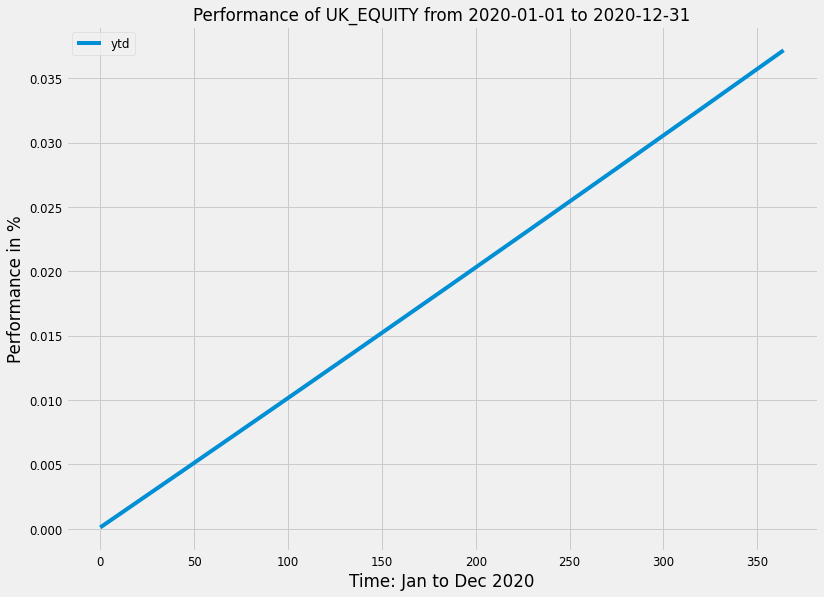

In [16]:
time_series_performance()